In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionF

## For digit recognition

In [6]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import random
from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from keras import backend as K
 
num_classes = 10
epochs = 20
 
def euclid_dis(vects):
    x,y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
   
    n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
   
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
        return np.array(pairs), np.array(labels)
 
 
def create_base_net(input_shape):
   
    input = Input(shape = input_shape)
    x = Conv2D(4, (5,5), activation = 'tanh')(input)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Conv2D(16, (5,5), activation = 'tanh')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Flatten()(x)
    x = Dense(10, activation = 'tanh')(x)
    model = Model(input, x)
    model.summary()
    return model
 
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
 
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
 
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
x_train /= 255
x_test /= 255
 
input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

(60000, 28, 28, 1)


In [7]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
 
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
 
# network definition
base_network = create_base_net(input_shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570

In [8]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)
#train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Epoch 1/20
85/85 [==============================] - 1s 6ms/step - loss: 0.1019 - accuracy: 0.8905 - val_loss: 0.0350 - val_accuracy: 0.9815
Epoch 2/20
85/85 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.9703 - val_loss: 0.0276 - val_accuracy: 0.9787
Epoch 3/20
85/85 [==============================] - 0s 5ms/step - loss: 0.0289 - accuracy: 0.9791 - val_loss: 0.0197 - val_accuracy: 0.9866
Epoch 4/20
85/85 [==============================] - 0s 5ms/step - loss: 0.0210 - accuracy: 0.9839 - val_loss: 0.0166 - val_accuracy: 0.9866
Epoch 5/20
85/85 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.9853 - val_loss: 0.0152 - val_accuracy: 0.9821
Epoch 6/20
85/85 [==============================] - 0s 4ms/step - loss: 0.0137 - accuracy: 0.9880 - val_loss: 0.0113 - val_accuracy: 0.9899
Epoch 7/20
85/85 [==============================] - 0s 4ms/step - loss: 0.0110 - accuracy: 0.9877 - val_loss: 0.0094 - val_accuracy: 0.9899
Epoch 8/20
85/85 [==

In [9]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)
 
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.88%
* Accuracy on test set: 99.10%


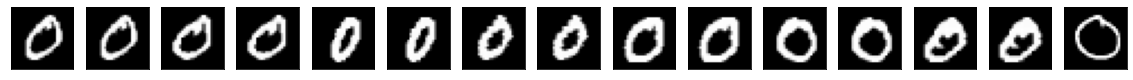

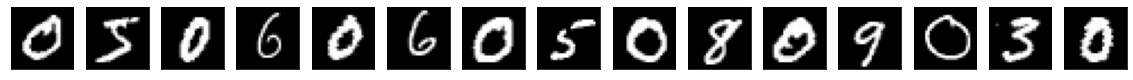

[0.00635203]
[2.8738492]
[0.0067051]
[3.0857565]
[0.00235888]
[3.7125723]
[0.0050294]
[2.1416054]
[0.0044698]
[2.6711745]
[0.00631737]
[2.3014915]
[0.00671114]
[2.9222574]
[0.00271888]


In [10]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 15

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None)
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
for i in range(number_of_items):
    print(y_pred[i])

## For signature recognition

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import model_from_json, Sequential, Model, load_model
from keras.optimizers import RMSprop
from keras import optimizers, callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
import json
import warnings
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score

In [12]:
train_dir="../input/signature-verification-dataset/sign_data/train/"
train_csv="../input/signature-verification-dataset/sign_data/train_data.csv"
test_csv="../input/signature-verification-dataset/sign_data/test_data.csv"
test_dir="../input/signature-verification-dataset/sign_data/test/"

In [13]:
df_train=pd.read_csv(train_csv)
df_train.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [14]:
df_test = pd.read_csv(test_csv)
df_test.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


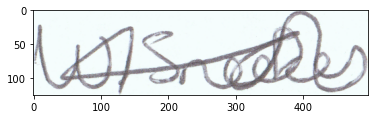

In [15]:
img = plt.imread(train_dir+df_train.iat[1,0])
plt.imshow(img)

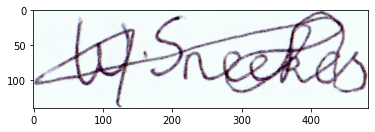

In [16]:
img = plt.imread(train_dir+df_train.iat[1,1])
plt.imshow(img)

### Data preprocessing

In [17]:
# test images

test_images1 = []
test_images2 = []
for j in range(0,len(df_test)):
    img1 = cv2.imread(test_dir+df_test.iat[j,0])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1, (100, 100))
    test_images1.append(img1)
    
    img2 = cv2.imread(test_dir+df_test.iat[j,1])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img2, (100, 100))
    test_images2.append(img2)

test_images1 = np.array(test_images1)/255.0
test_images2 = np.array(test_images2)/255.0

In [18]:
# train images

train_images1 = []
train_images2 = []
train_labels = []

for i in range(len(df_train)):
    img1 = cv2.imread(train_dir+df_train.iat[i,0])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1, (100, 100))
    train_images1.append(img1)
    
    img2 = cv2.imread(train_dir+df_train.iat[i,1])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img2, (100, 100))
    train_images2.append(img2)
    
    train_labels.append(df_train.iat[i,2])
    
train_images1 = np.array(train_images1)/255.0
train_images2 = np.array(train_images2)/255.0
train_labels = np.array(train_labels)

In [19]:
train_images1 = np.expand_dims(train_images1, -1)
train_images2 = np.expand_dims(train_images2, -1)
test_images1 = np.expand_dims(test_images1, -1)
test_images2 = np.expand_dims(test_images2, -1)

### Siamese network

In [20]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def build_base_network(input_shape):
    model = Sequential()
    kernel_size = 3
    
    # conv layer 1
    model.add(Convolution2D(64, (kernel_size, kernel_size), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(Dropout(.25))
    
    model.add(Convolution2D(32, (kernel_size, kernel_size)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(.25))
    
    # conv layer 2
    model.add(Convolution2D(32, (kernel_size, kernel_size)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(.25))

    # flatten 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    return model

In [21]:
input_dim = (100,100,1)

base_network = build_base_network(input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

prediction = Dense(1,activation='sigmoid')(distance)

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

callback_early_stop_reduceLROnPlateau=[earlyStopping]

model = Model([img_a, img_b],prediction)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           444530      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential[0][0]           

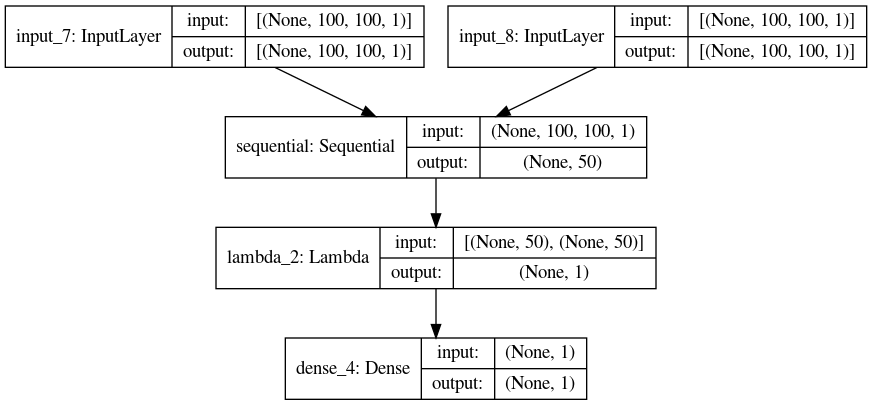

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [24]:
history = model.fit([train_images1,train_images2], train_labels, validation_split=.10,
      batch_size= 32, verbose=1, epochs=8, callbacks=callback_early_stop_reduceLROnPlateau)

Epoch 1/8
653/653 [==============================] - 12s 17ms/step - loss: 0.7224 - accuracy: 0.4684 - val_loss: 0.6929 - val_accuracy: 0.5118
Epoch 2/8
653/653 [==============================] - 10s 16ms/step - loss: 0.6917 - accuracy: 0.5467 - val_loss: 0.6929 - val_accuracy: 0.5118
Epoch 3/8
653/653 [==============================] - 10s 16ms/step - loss: 0.6911 - accuracy: 0.5439 - val_loss: 0.6929 - val_accuracy: 0.5118
Epoch 4/8
653/653 [==============================] - 10s 16ms/step - loss: 0.6902 - accuracy: 0.5479 - val_loss: 0.6931 - val_accuracy: 0.5118
Epoch 5/8
653/653 [==============================] - 10s 16ms/step - loss: 0.6525 - accuracy: 0.6183 - val_loss: 0.4255 - val_accuracy: 0.9138
Epoch 6/8
653/653 [==============================] - 10s 16ms/step - loss: 0.4451 - accuracy: 0.8877 - val_loss: 0.3508 - val_accuracy: 0.9509
Epoch 7/8
653/653 [==============================] - 10s 16ms/step - loss: 0.3553 - accuracy: 0.9688 - val_loss: 0.3171 - val_accuracy: 0.9668

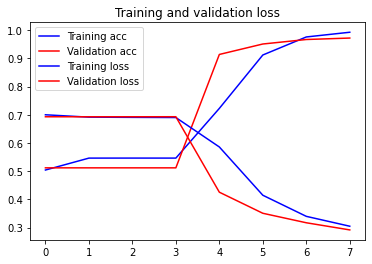

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
 
plt.figure()

### Prediction

In [26]:
pred_y = model.predict([test_images1,test_images2])

In [27]:
test_labels = np.array(df_test['1'])
accuracy_score(pred_y.argmax(axis=1), test_labels)

0.4823386114494519